# **Lab3 : Image Segmentation (Histogram of Oriented Gradients & K-Mean Clustering)**

In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.feature import hog
from skimage import measure


import glob

from sklearn.cluster import KMeans

from scipy import spatial

from tqdm import tqdm
import cv2
import os 
import random

## Load Image

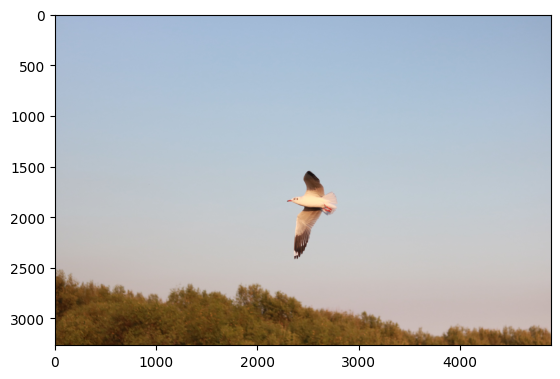

In [5]:
### START CODE HERE ###
image = cv2.imread("./img3.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
### END CODE HERE ###

## Histogram of Oriented Gradients

Blur the image then apply to the [`hog()`](<https://scikit-image.org/docs/stable/api/skimage.feature.html#skimage.feature.hog:~:text=skimage.feature.hog(,%23>)
<details>

<summary>
<font size="3" color="orange">
<b>Expected output</b>
</font>
</summary>

- The output should resemble this, but not be identical

![image.png](https://raw.githubusercontent.com/Digital-Image-Processing-Laboratory/Image-Processing-Course-2025/refs/heads/main/Lab3_Image-Segmentation/asset/1.png?raw=true)
</details>

47.13098907470703 0.0


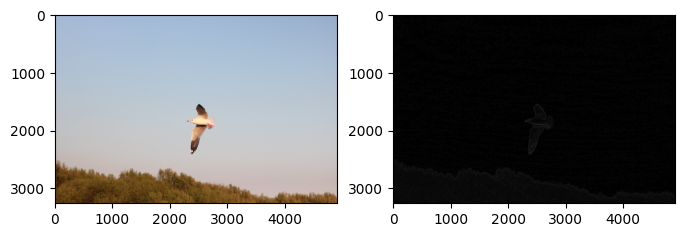

In [7]:
### START CODE HERE ###
# blurry_image = cv2.GaussianBlur(np.array(image), (25, 25), 5)
# fd, hog_image = hog(
#     blurry_image,
#     orientations=9,
#     pixels_per_cell=(8, 8),
#     cells_per_block=(2, 2),
#     visualize=True,
#     channel_axis=-1
# )


# fig, axs = plt.subplots(1, 2, figsize=(12, 6))
# axs[0].imshow(blurry_image)
# axs[0].set_title('Blur')

# axs[1].imshow(hog_image, cmap='gray')
# axs[1].set_title('HOG')
blurry_image = cv2.GaussianBlur(image,(15,15),0)
fd, hog_image = hog(blurry_image, orientations=9, pixels_per_cell=(4, 4), 
                cells_per_block=(2, 2), visualize=True,channel_axis=-1)
fig, ax = plt.subplots(1, 2, figsize=(8, 8)) 
ax[0].imshow(blurry_image)
ax[1].imshow(hog_image**0.5,cmap='gray')
print(hog_image.max(),hog_image.min())

### END CODE HERE ###

Complete the `HOGSubimageExtractor()`.

That extracts Histogram of Oriented Gradients features from sub-images of a larger image. It divides the image into overlapping tiles, computes HOG features for each tile, and stores both the feature vectors and visualizations. The class also provides a method to plot the HOG visualizations.

**Attributes:**
- `image`: The input image.
- `tile_size`: The size of each sub-image to extract.
- `stride`: The pixel stride between consecutive sub-images.
- `hGrid`: An array of indices representing the starting positions for rows of sub-images.
- `wGrid`: An array of indices representing the starting positions for columns of sub-images.
- `hog_features`: A list to store the HOG feature vectors for each sub-image.
- `hog_images`: A list to store the visualized HOG images for each sub-image (optional).

**Methods:**
- `extract_hog_features()`: Compute HOG features for each sub-image.
- `plot_hog_images()`: Plots the HOG visualization images.
- `get_num_grid()`: Return the number of rows and columns in the grid of sub-images.


In [24]:
### START CODE HERE ###
class HOGSubimageExtractor:
    def __init__(self, image, tile_size, stride):
        self.image = image
        self.tile_size = tile_size
        self.stride = stride
        self.h, self.w, _ = image.shape
        self.hGrid = np.arange(0, self.h - self.tile_size[0] + 1, self.stride)
        self.wGrid = np.arange(0, self.w - self.tile_size[1] + 1, self.stride)
        self.hog_features = []
        self.hog_images = []
        self.extract_hog_features()

    def extract_hog_features(self):
        self.hog_features = []
        self.hog_images = []
        for i in self.hGrid:
            for j in self.wGrid:
                sub_img = self.image[i:i+self.tile_size[0], j:j+self.tile_size[1]]
                fd, hog_img = hog(
                    sub_img,
                    orientations=9,
                    pixels_per_cell=(8, 8),
                    cells_per_block=(4, 4),
                    visualize=True,
                    channel_axis=-1
                )
                self.hog_features.append(fd)
                self.hog_images.append(hog_img)
        

    def plot_hog_images(self):
        num_rows, num_cols = self.get_num_grid()
        fig, axs = plt.subplots(num_rows, num_cols, figsize=(3*num_cols, 3*num_rows))
        axs = np.array(axs).reshape(num_rows, num_cols)
        for idx, hog_img in enumerate(self.hog_images):
            row = idx // num_cols
            col = idx % num_cols
            axs[row, col].imshow(hog_img, cmap='gray')
            axs[row, col].axis('off')
        plt.tight_layout()
        plt.show()
        

    def get_num_grid(self):
        return len(self.hGrid), len(self.wGrid)
### END CODE HERE ###


Let's use `HOGSubimageExtractor()` in the cell below.
<details>

<summary>
<font size="3" color="orange">
<b>Expected output from hog_extractor.plot_hog_images()</b>
</font>
</summary>

- The output should resemble this, but not be identical

![image.png](https://raw.githubusercontent.com/Digital-Image-Processing-Laboratory/Image-Processing-Course-2025/refs/heads/main/Lab3_Image-Segmentation/asset/2.png)
</details>

Number of grids: (11, 18)


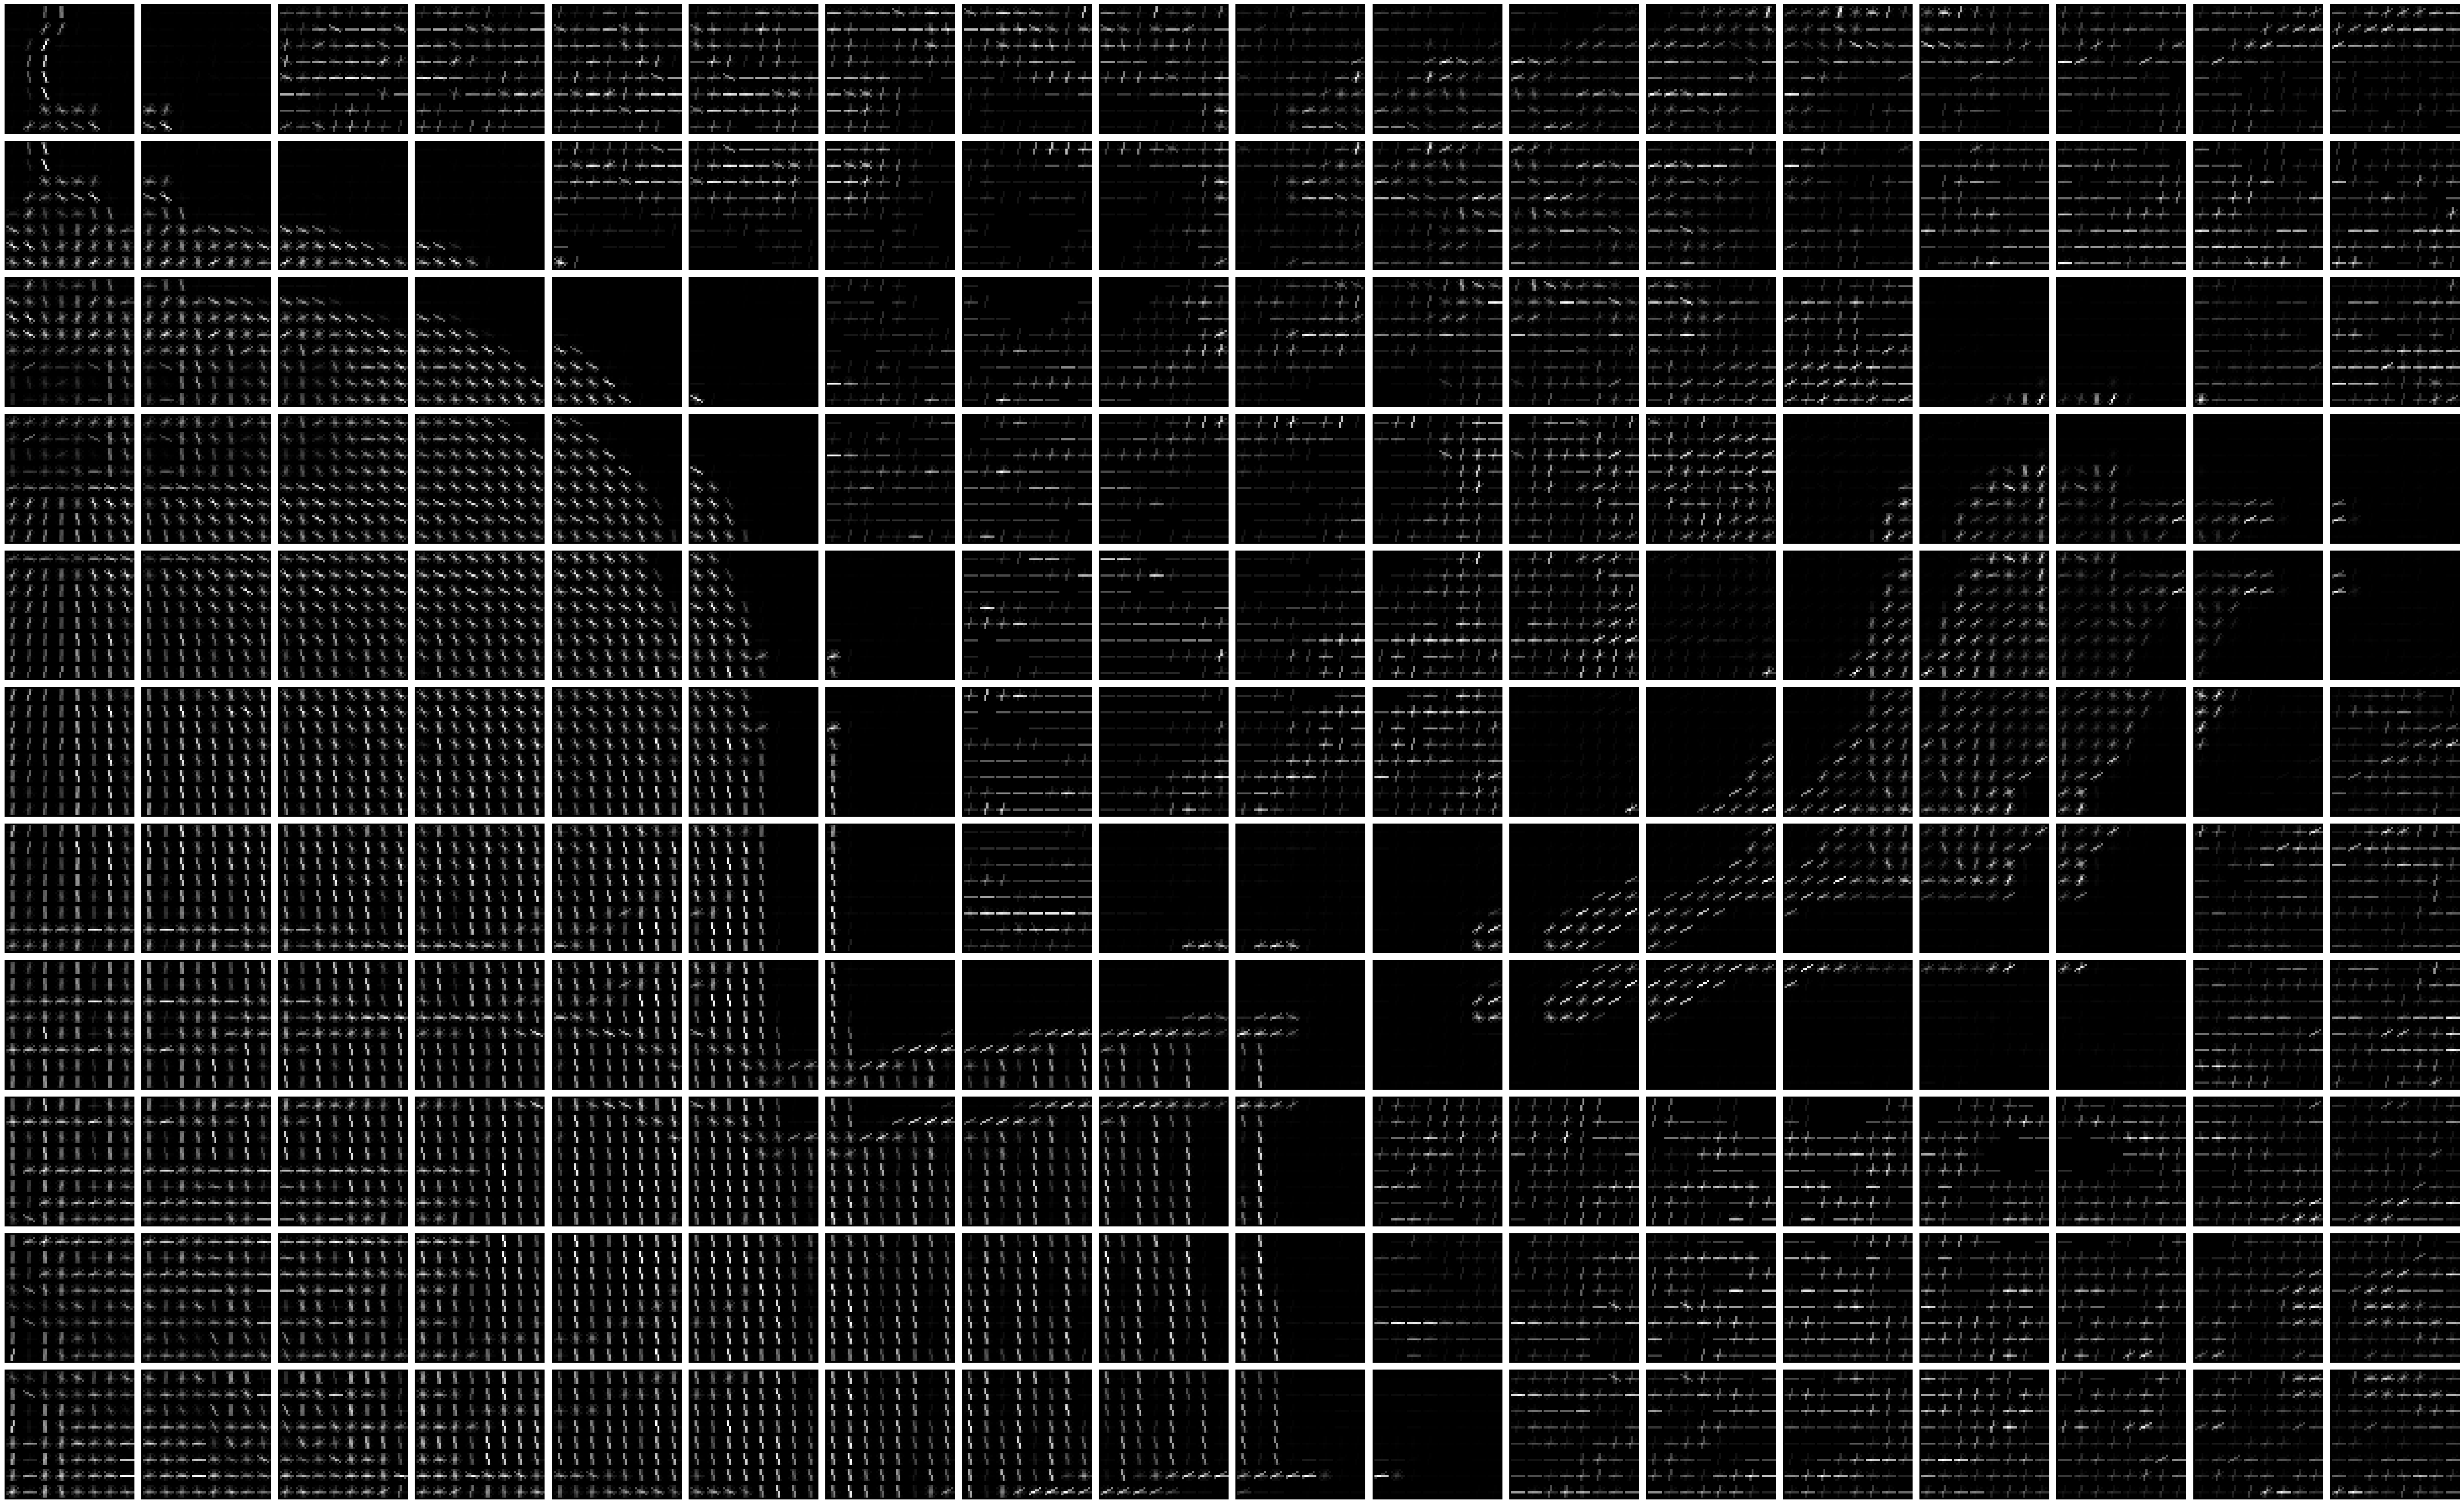

In [25]:
### START CODE HERE ###
tile_size = (64, 64)
stride = 32
hog_extractor = HOGSubimageExtractor(image, tile_size, stride)
num_grid = hog_extractor.get_num_grid()
print(f'Number of grids: {num_grid}')
hog_extractor.plot_hog_images()
### END CODE HERE ###


## K-Mean Clustering
Complete the `KMeansCluster()`.
Perform K-means clustering on Histogram of Oriented Gradients (HOG) features extracted from an image.
**Attriburtes:**
- `hog_extractor`: An object responsible for extractin HOG features from an image.
- `n_clusters`: The number of clusters to use in K-means.
- `cluster_array`: A 2D array representing the cluster assignments for each grid cell.
- `all_labels`: A 2D array representing the connected components (objects) identified after clustering.
- `bounding_boxes`: A list of tuples containing (object_id, start_coordinates, end_coordinates) for each detected object.

**Method:**
- `perform_clustering()`: Performs K-means clustering on the HOG features extracted by the hog_extractor object.<br>
It then reshapes the cluster assignmentss into a grid and identifies connected components using the `measure.label()` function.
- `plot_cluster_and_labels()`: Visualize the cluster assignments and connected components as images using Matplotlib.
- `get_bounding_boxes()`: Extracts bounding boxes for each detected object.

In [26]:
tile_size = (64, 64)
stride = 16
hog_extractor = HOGSubimageExtractor(image, tile_size, stride)

[2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2
 0 0 0 0 0 0 3 3 3 3 0 1 1 1 2 2 0 0 0 0 0 0 3 3 3 3 0 1 1 1 1 2 2 0 0 0 0
 3 3 3 3 3 0 1 1 1 1 1 2 0 0 0 0 3 3 3 3 0 0 1 1 1 1 1 2 2 2 0 0 3 0 0 0 0
 0 1 1 1 1 1 1 1 2 2 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 2 0 0 0 0 0 0 0]
(0, 0, 9, 9)
(2, 10, 7, 15)
(3, 0, 9, 8)
bounding boxes: [[1, (0, 0), (384, 384)], [2, (320, 64), (576, 320)], [3, (0, 96), (352, 384)]]


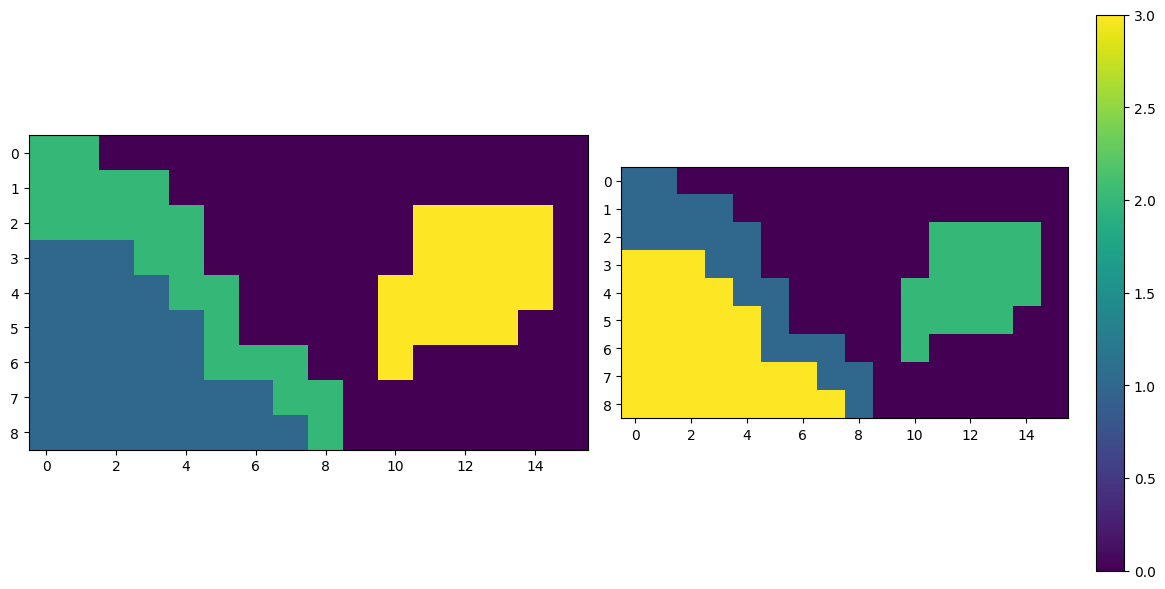

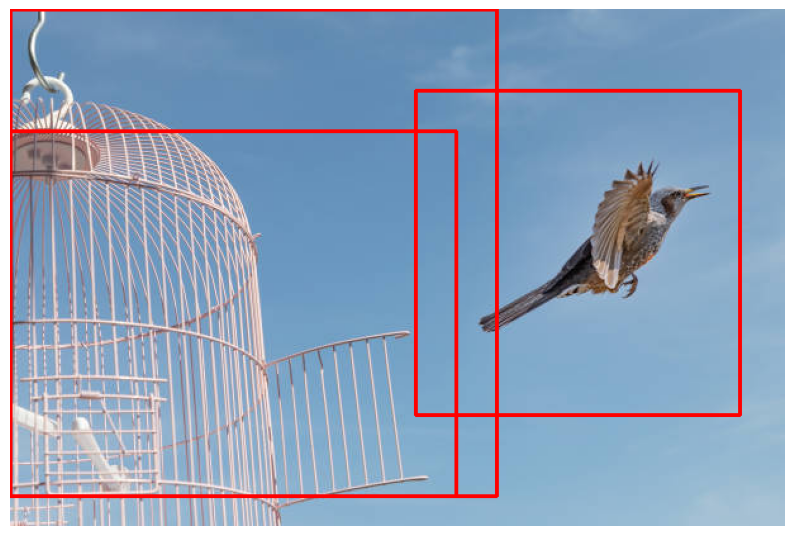

In [ ]:
elbow_method
cilu_weight_score

### START CODE HERE ###
class KMeansCluster:
    def __init__(self, hog_extractor, n_clusters, random_state=42):
        self.hog_extractor = hog_extractor
        self.n_clusters = n_clusters
        self.random_state = random_state
        self.cluster_array = None
        self.all_labels = None
        self.bounding_boxes = []
        self.perform_clustering()

    def perform_clustering(self):
        hog_features_array = np.array(self.hog_extractor.hog_features)
        
        kmeans = KMeans(n_clusters=self.n_clusters, random_state=self.random_state, n_init=10)
        kmeans.fit(hog_features_array)
        
        cluster_assignments = kmeans.labels_
        num_rows, num_cols = self.hog_extractor.get_num_grid()
        self.cluster_array = cluster_assignments.reshape(num_rows, num_cols)

        self.all_labels = measure.label(self.cluster_array)
        print(cluster_assignments)
        self.get_bounding_boxes()

    def plot_cluster_and_labels(self):
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))
        ax1 = axes[0]
        ax1.imshow(self.cluster_array, cmap='viridis') 
        
        ax2 = axes[1]
        im = ax2.imshow(self.all_labels, cmap='viridis') 

        fig.colorbar(im, ax=ax2)

        plt.tight_layout()
        plt.show()

    def get_bounding_boxes(self):
        self.bounding_boxes = []
        for region in measure.regionprops(self.all_labels):
            if (region.area < 10):
                continue
            print(region.bbox)
            min_row, min_col, max_row, max_col = region.bbox
            
            start_y_pixel = min_row * self.hog_extractor.stride
            start_x_pixel = min_col * self.hog_extractor.stride

            end_y_pixel = max_row * self.hog_extractor.stride + (self.hog_extractor.tile_size[0] - self.hog_extractor.stride) 
            end_x_pixel = max_col * self.hog_extractor.stride + (self.hog_extractor.tile_size[0] - self.hog_extractor.stride)
            
            self.bounding_boxes.append([
                region.label,
                (start_x_pixel, start_y_pixel),
                (end_x_pixel, end_y_pixel),
                # region.area
            ])
        print(f"bounding boxes: {self.bounding_boxes}")
        return self.bounding_boxes

def draw_bbox(image, bboxes):
    img_copy = image.copy()
    for obj_id, (start_x, start_y), (end_x, end_y) in bboxes:
        cv2.rectangle(img_copy, (start_x, start_y), (end_x, end_y), (255, 0, 0), 2)
    plt.figure(figsize=(10, 10))
    plt.imshow(img_copy)
    plt.axis('off')
    plt.show()

kmeans_cluster = KMeansCluster(hog_extractor, n_clusters=4)
kmeans_cluster.plot_cluster_and_labels()
bboxes = kmeans_cluster.bounding_boxes
draw_bbox(image,bboxes)
### END CODE HERE ###

Complete the function below. Using [`cv2.rectangle()`](<https://docs.opencv.org/4.x/dc/da5/tutorial_py_drawing_functions.html#:~:text=511%2C511)%2C(255%2C0%2C0)%2C5)-,Drawing%20Rectangle,-To%20draw%20a>)

Let's use `KMeansCluster()` and `draw_bbox()` in the cell below.
<details>

<summary>
<font size="3" color="orange">
<b>Expected output</b>
</font>
</summary>

- The output should resemble this, but not be identical

![image-3.png](https://raw.githubusercontent.com/Digital-Image-Processing-Laboratory/Image-Processing-Course-2025/refs/heads/main/Lab3_Image-Segmentation/asset/3.png?raw=true)

![image-4.png](https://raw.githubusercontent.com/Digital-Image-Processing-Laboratory/Image-Processing-Course-2025/refs/heads/main/Lab3_Image-Segmentation/asset/4.png?raw=true)
</details>

(0, 1, 22, 35)
bounding boxes: [[1, (16, 0), (608, 400)]]


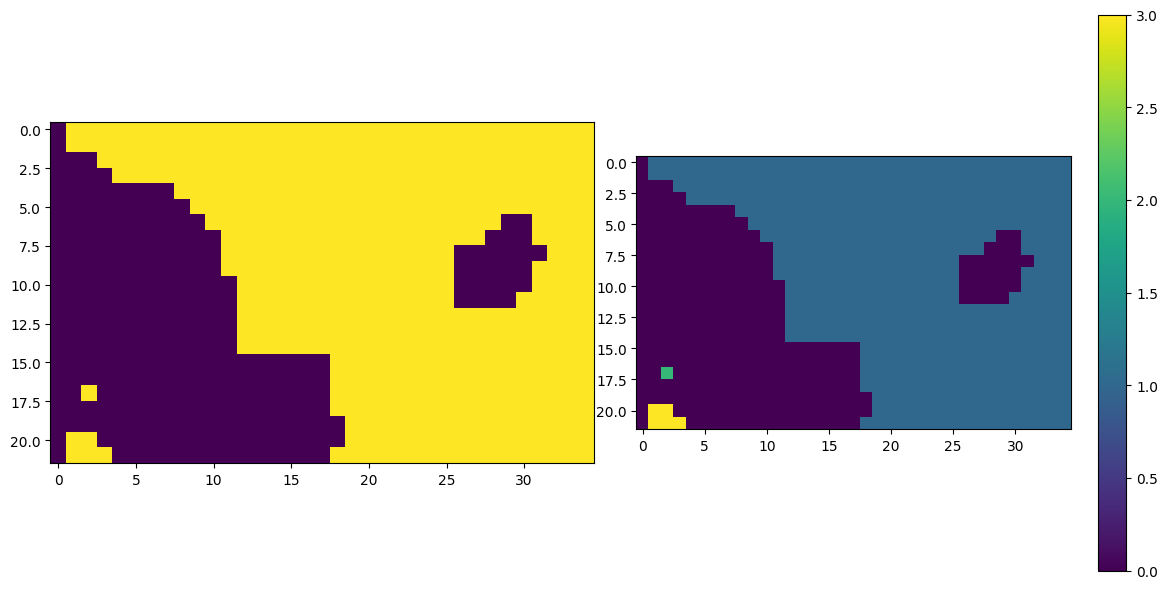

In [28]:
kmeans_cluster = KMeansCluster(hog_extractor, n_clusters=2, random_state=42)
kmeans_cluster.plot_cluster_and_labels()
# bboxes = kmeans_cluster.get_bounding_boxes()
# draw_bbox(image,bboxes)

---

## Experiment
Do the experiment to identify 3 best parameters that produce the perfectly fitting bounding box of the object of interest in the image.

(0, 1, 6, 10)
(2, 0, 6, 5)
bounding boxes: [[1, (64, 0), (608, 352)], [2, (0, 128), (288, 352)]]


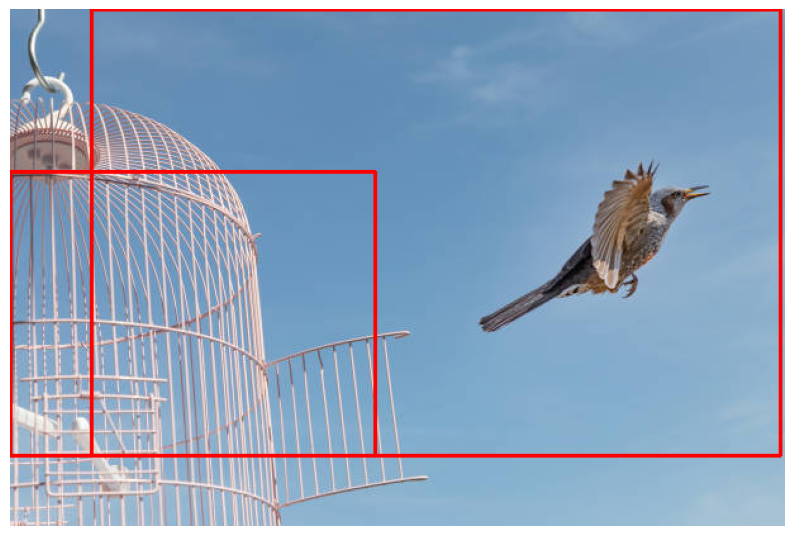

In [29]:
### START CODE HERE ###

tile_size = (32, 32)
stride = 64

hog_extractor = HOGSubimageExtractor(image, tile_size, stride)
kmeans_cluster = KMeansCluster(hog_extractor, n_clusters=3)
bboxes = kmeans_cluster.bounding_boxes
draw_bbox(image,bboxes)


### END CODE HERE ###

[1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0
 2 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 1 1 2 2 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 1 1 0 0 0 0 0
 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0 0
 1 2 2 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0
 2 2 2 2 2 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0
 2 2 2 2 2 2 2 2 2 2 2 1 1 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0 0 0 0
 2 2 2 2 2 2 2 2 2 2 2 2 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0
 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0 0 0 0 0
 2 2 2 2 2 2 2 2 2 2 2 2 

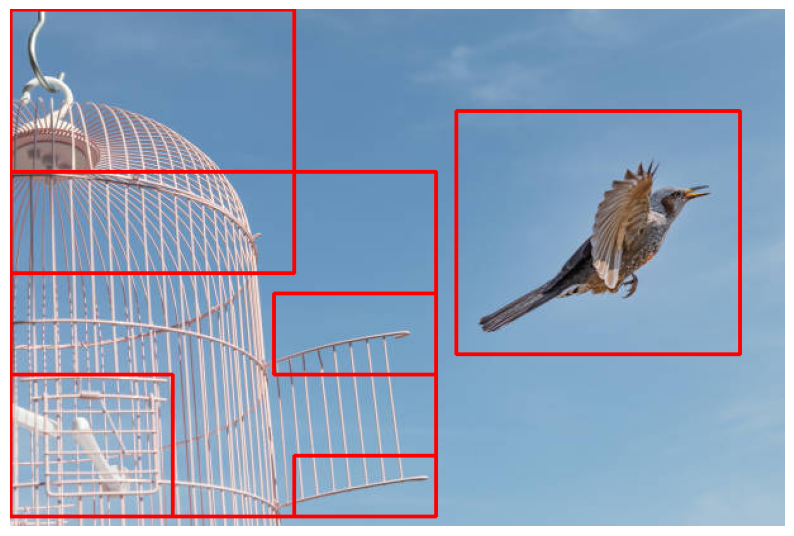

In [69]:
### START CODE HERE ###

tile_size = (32, 32)
stride = 16

hog_extractor = HOGSubimageExtractor(image, tile_size, stride)
kmeans_cluster = KMeansCluster(hog_extractor, n_clusters=3)
bboxes = kmeans_cluster.bounding_boxes
draw_bbox(image,bboxes)

### END CODE HERE ###

[1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1
 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1
 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1
 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1
 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 2 2 2 0 0 1 1 1 1 1 1 1 1 1 2 2 2
 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 2 0 0 0 0 1 1 1 1 1 1 1 1 2 2 2 2
 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 2 2 0 0 0 0 0 0 0 0 0 0 1 1 2 2 2 2 2 2
 2 2 2 2 2 1 1 1 1 1 1 1 1 1 2 2 2 0 0 0 0 0 0 0 0 0 0 0 1 2 2 2 2 2 2 2 2
 2 2 2 1 1 1 1 1 1 1 1 1 2 2 2 0 0 0 0 0 0 0 0 0 0 0 1 2 2 2 2 2 2 2 2 2 2
 1 1 1 1 1 1 1 1 1 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 1 2 2 2 2 2 2 2 2 2 1 1 1
 1 1 1 1 1 1 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 1 2 2 2 2 2 2 2 2 2 1 1 1 1 1
 2 2 2 2 2 2 2 2 2 0 0 0 

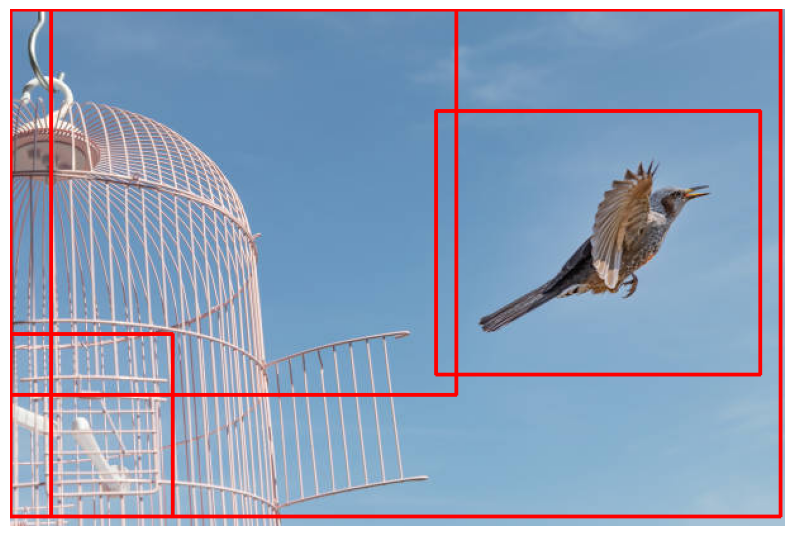

In [68]:
### START CODE HERE ###

tile_size = (32, 32)
stride = 16

hog_extractor = HOGSubimageExtractor(image, tile_size, stride)
kmeans_cluster = KMeansCluster(hog_extractor, n_clusters=3)
bboxes = kmeans_cluster.bounding_boxes
draw_bbox(image,bboxes)


### END CODE HERE ###

---

## **Question** 

1. How do the parameters of Gaussian blur, such as kernel size and standard deviation, affect the image processing in the context of k-means clustering?\
ตอบ\
ถ้า kernel size มากอาจทำให้วัตถุเบลอเกินไป


\
2. How do the configurations of cells per block and pixels per cell influence the effectiveness of object detection in an image?\
ตอบ\
pixels per cell เล็ก ทำให้จับวัตถุขนาดเล็กได้ แต่ใช้เวลาในการคำนวณนานขึ้น pixels per cell ใหญ่ ได้ภาพรวมของวัตถุ เหมาะกับการจับวัตถุขนาดใหญ่ คำนวณเร็วกว่า ส่วน cells per block ใหญ่ ทำให้ block ครอบคลุมพื้นที่กว้าง cells per block เล็ก รองรับการเปลี่ยนแปลงเฉพาะจุดมากขึ้น


\
\
3. What differences can be observed in the clustering results when using smaller sub-images (tiles) compared to larger ones?\
ตอบ\
small tiles ได้การจัดกลุ่มที่ละเอียดและแม่นยำขึ้น มีจำนวนกลุ่มมาก ส่วน large tiles อาจรวมวัตถุหลายอย่างไว้ในก้อนเดียว เพราะข้อมูลถูกลดรายละเอียดบางส่วนลง และมีจำนวนกลุ่มน้อยกว่า


\
\
4. What is the impact on object detection if the labeling step is skipped before applying k-means clustering?\
ตอบ\
มันจะรวมวัตถุหลายวัตถุไว้ด้วยกัน ทำให้ bounding box ที่ได้ไม่แม่นยำ

\
\
5. How does the choice of the number of clusters (K) in k-means clustering affect the image clustering result (right) of an input image (left)? 
Discuss the trade-offs between too few and too many clusters in accurately representing the test patterns.<br>\
ตอบ\
ถ้าเลือก k น้อย จะทำให้แยกวัตถุไม่ค่อยได้ เพราะถูกมองว่าเป็นกลุ่มเดียวกัน
ถ้า k มาก จะทำให้ detect เจอ object ได้มากเกินไป โดยไม่จำเป็น

![q5.jpg](https://raw.githubusercontent.com/Digital-Image-Processing-Laboratory/Image-Processing-Course-2025/refs/heads/main/Lab3_Image-Segmentation/asset/q5.jpg?raw=true)


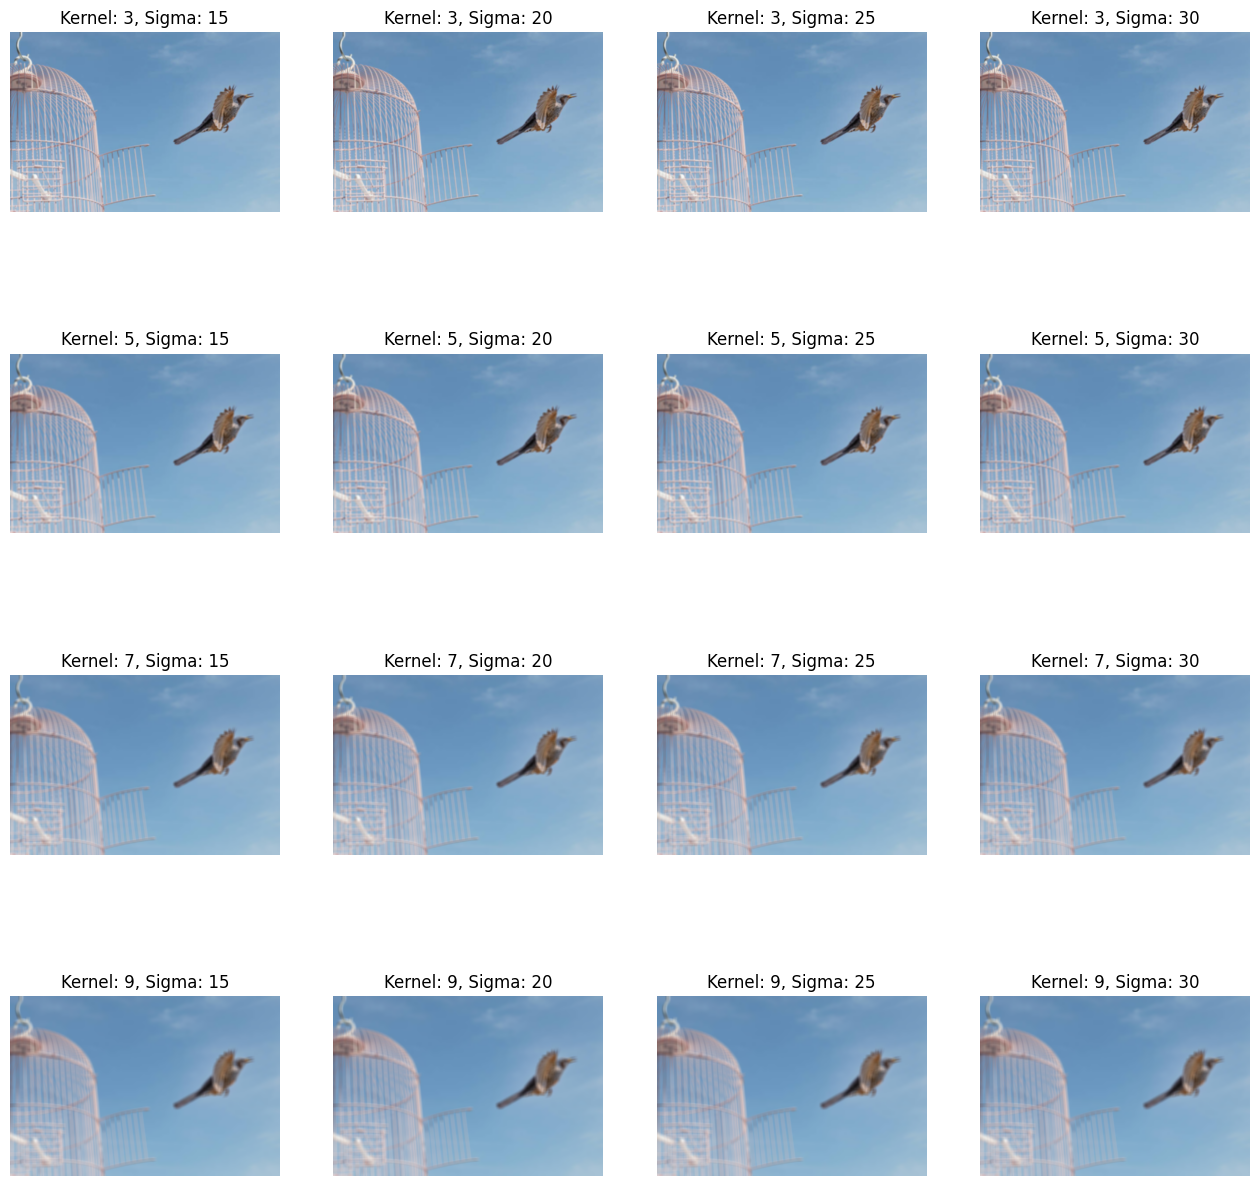

In [ ]:
# ข้อ 1
# blurry_image = cv2.GaussianBlur(np.array(image), (5, 5), sigmaX=5, sigmaY=5)

fig, axs = plt.subplots(4,4, figsize=(16, 16))
size = [3, 5, 7, 9]
for i in range(4):
    for j in range(3, 7):
        axs[i, j-3].imshow(cv2.GaussianBlur(np.array(image), (size[i], size[i]), sigmaX=j*5, sigmaY=j*5))
        axs[i, j-3].set_title(f'Kernel: {size[i]}, Sigma: {j*5}')
        axs[i, j-3].axis('off')
# fig, axs = plt.subplots(4,4, figsize=(12, 6))


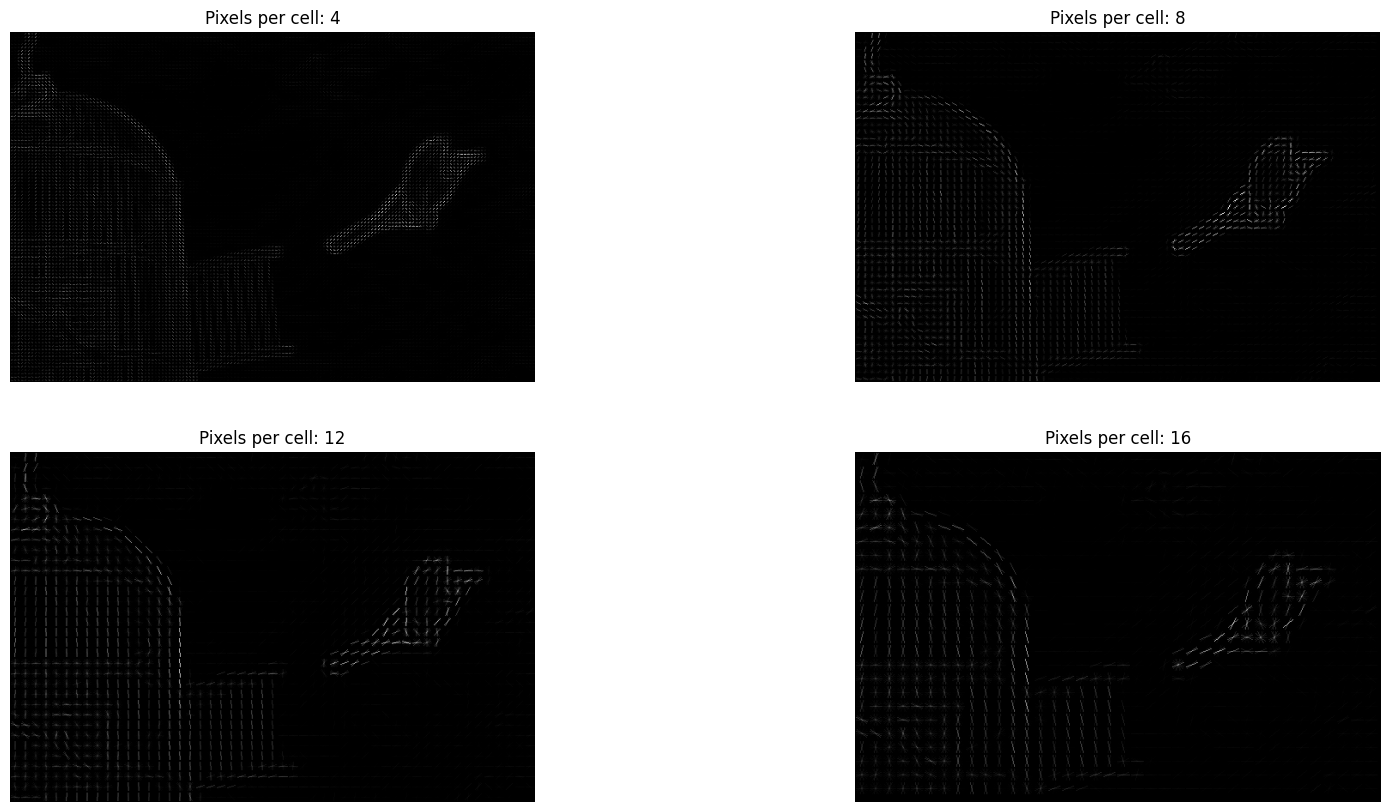

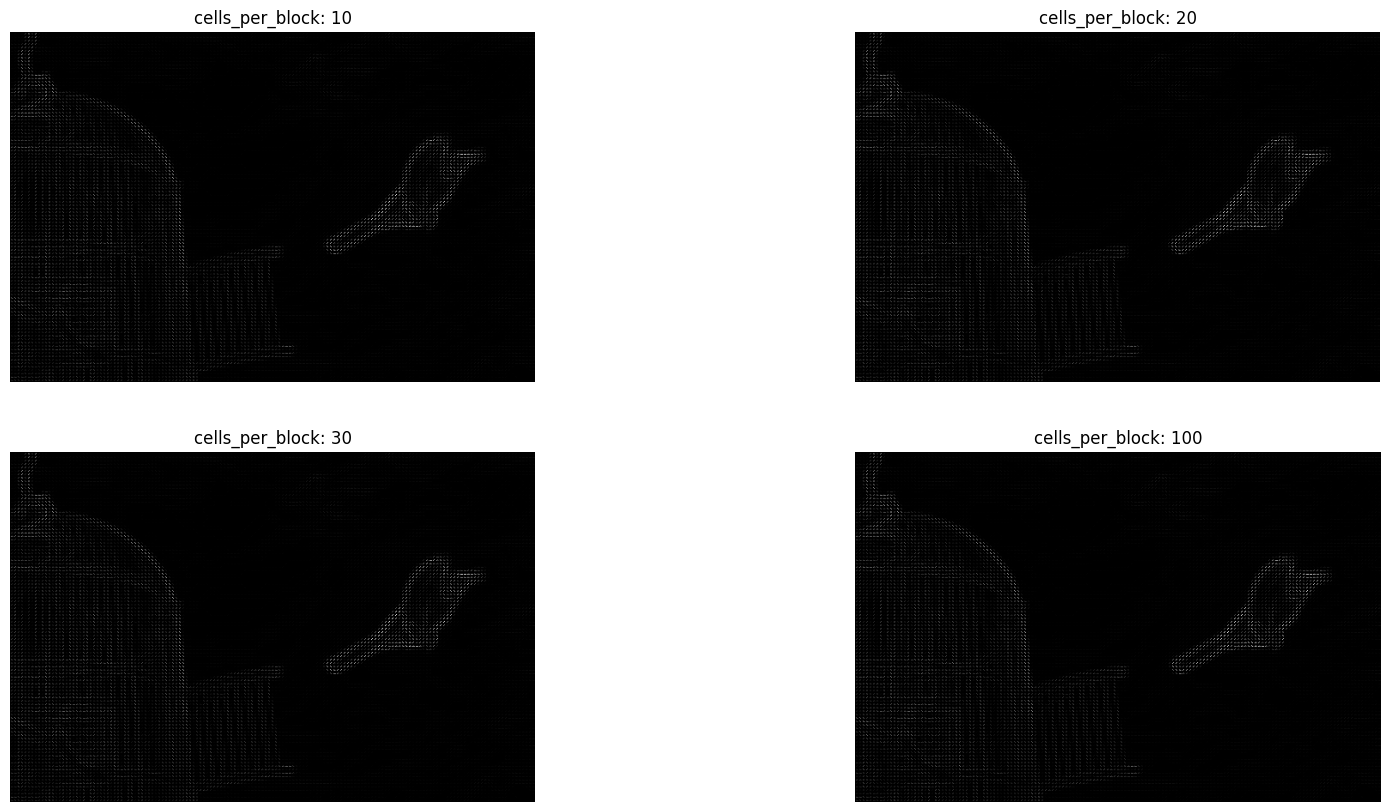

In [63]:
blurry_image = cv2.GaussianBlur(np.array(image), (9, 9), sigmaX=15, sigmaY=15)
fig, axs = plt.subplots(2, 2, figsize=(20, 10))
arr = [4, 8, 12, 16]
for k in range(2):
    for j in range(2):
        i = k * 2 + j
        fd, hog_image = hog(
            blurry_image,
            orientations=9,
            pixels_per_cell=(arr[i], arr[i]),
            cells_per_block=(2, 2),
            visualize=True,
            channel_axis=-1,
        )
        axs[k][j].imshow(hog_image, cmap="gray")
        axs[k][j].set_title(f'Pixels per cell: {arr[i]}')
        axs[k][j].axis('off')

# ค่า sigmaX และ sigmaY ที่เหมาะสมจะขึ้นอยู่กับขนาดของ kernel และลักษณะของภาพ
# โดยทั่วไป ถ้า kernel ใหญ่ (เช่น (9,9)) ค่า sigma ที่เหมาะสมจะอยู่ที่ประมาณ 10-20
# ถ้า sigma ต่ำ (เช่น 1-5) จะเบลอไม่มาก ถ้า sigma สูง (เช่น 20-30) จะเบลอมากจนรายละเอียดหายไป
# แนะนำให้ลองใช้ sigmaX=10, sigmaY=10 หรือ sigmaX=15, sigmaY=15 จะเห็นผลชัดเจน
# สามารถทดลองปรับค่า sigmaX, sigmaY ในช่วง 5-20 เพื่อดูผลลัพธ์ที่แตกต่างกัน

# ตัวอย่าง
# blurry_image = cv2.GaussianBlur(np.array(image), (9, 9), sigmaX=10, sigmaY=10)
# blurry_image = cv2.GaussianBlur(np.array(image), (9, 9), sigmaX=15, sigmaY=15)
# blurry_image = cv2.GaussianBlur(np.array(image), (9, 9), sigmaX=20, sigmaY=20)
fig, axs = plt.subplots(2, 2, figsize=(20, 10))
arr = [
    10, 20 ,30, 100
]
for k in range(2):
    for j in range(2):
        i = k * 2 + j
        fd, hog_image = hog(
            blurry_image,
            orientations=9,
            pixels_per_cell=(4, 4),
            cells_per_block=(arr[i], arr[i]),
            visualize=True,
            channel_axis=-1,
        )  
        axs[k][j].imshow(hog_image, cmap="gray")
        axs[k][j].set_title(f'cells_per_block: {arr[i]}')
        axs[k][j].axis('off')